# Read and Extract ROI from LUNA16 dataset

Follows [this article](https://notebook.community/mas-dse-greina/neon/luna16/old_code/LUNA16_loader).

In [2]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import os
from os.path import join as path_join

import matplotlib.pyplot as plt
import ntpath
%matplotlib inline

In [3]:
LUNA_FOLDER = "../data/LUNA16"

# Images folder
LUNA_SEG_FOLDER = path_join(LUNA_FOLDER, "seg-lungs-LUNA16")
LUNA_SUBSET_0 = path_join(LUNA_FOLDER, "subset0")

LUNA_CANDIDATES_CSV = path_join(LUNA_FOLDER, "candidates.csv")
LUNA_ANNOTATIONS_CSV = path_join(LUNA_FOLDER, "annotations.csv")

## Histogram of Nodules

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


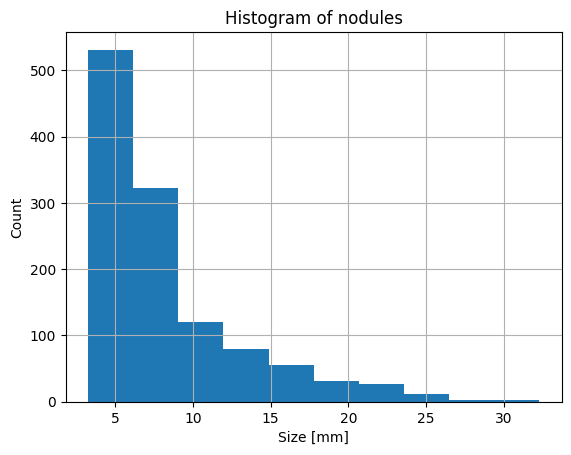

In [4]:
df_annotations = pd.read_csv(LUNA_ANNOTATIONS_CSV)
display(df_annotations.head())
df_annotations['diameter_mm'].hist();
plt.title('Histogram of nodules');
plt.xlabel('Size [mm]');
plt.ylabel('Count');

In [5]:
df_candidates = pd.read_csv(LUNA_CANDIDATES_CSV)
df_candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


## Image Normalization

- Converting pixel value to Hounsfield Units (HU)

In [6]:
"""
Normalize pixel depth into Hounsfield units (HU)

This tries to get all pixels between -1000 and 400 HU.
All other HU will be masked.

"""
def normalize_planes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

## Extract ROI Image Patches for Candidates

In [7]:
def extract_candidates(img_file: str):
    """
    extract_candidates: Extracts patches of ROI for candidates
    
    img_file: .mhd file
    candidates_file_path: candidates csv path
    """
    subject_name = os.path.splitext(os.path.basename(img_file))[0]
    
    df_subject_candidates = df_candidates[df_candidates["seriesuid"] == subject_name]
    num_candidates = df_subject_candidates.shape[0]
    num_non_nodules = df_subject_candidates[df_subject_candidates["class"] == 0]
    num_nodules = df_subject_candidates[df_subject_candidates["class"] == 1]
    
    # Read if a candidate ROI is a nodule or non nodule
    candidate_values = df_candidates["class"].values
    
    world_coordinates = df_subject_candidates[["coordX", "coordY", "coordZ"]]
    
    itk_image = sitk.ReadImage(path_join(LUNA_SEG_FOLDER, img_file))
    
    origin_matrix = np.tile(itk_image.GetOrigin(), (num_candidates, 1))
    
    # Subtract the real world origin and scale by the real world (mm per pixel)
    # This should give us the X,Y,Z coordinates for the candidates
    candidates_pixels = (np.round(np.absolute(world_coordinates - origin_matrix) / itk_image.GetSpacing())).astype(int)
    
    # Replace the missing diameters with the 50th percentile diameter
    candidates_diameter = df_annotations["diameter_mm"].fillna(df_annotations["diameter_mm"].quantile(.5))
    
    candidate_patches = []
    
    # Read the image volume
    img_all = sitk.GetArrayFromImage(itk_image)
    
    for cand_num in range(num_candidates):
        print("Extracting candidate patch #{}".format(cand_num))
        candidate_voxel = candidates_pixels[cand_num, :]
        x_pos = int(candidate_voxel[0])
        y_pos = int(candidate_voxel[1])
        z_pos = int(candidate_voxel[2])
        
        # Need to handle the candidates where the window would extend beyond the image boundaries
        window_size = 32
        x_lower = np.max([0, x_pos - window_size])
        x_upper = np.min([x_pos + window_size, itk_image.GetWidth()])
        
        y_lower = np.max([0, y_pos - window_size])
        y_upper = np.min([y_pos + window_size, itk_image.GetWidth()])
        
        # Simple itk is x,y,z. Numpy is z,y,x
        img_patch = img_all[z_pos, y_lower:y_upper, x_lower:x_upper]
        
        # Normalize to Hounsfield units
        # TODO: I dont think we should normalize to Hounsfield units
        img_patch_norm = img_patch # normalize_planes(img_patch)
        candidate_patches.append(img_patch_norm)
        
    return candidate_patches, candidate_values,  candidates_diameter


## Copied from LUNA16_loader

In [40]:
def extractCandidates(img_file):
    # Get the name of the file
    subjectName = ntpath.splitext(ntpath.basename(img_file))[0]  # Strip off the .mhd extension
    
    # Read the list of candidate ROI
    dfCandidates = pd.read_csv(LUNA_CANDIDATES_CSV)
    dfAnnotations = pd.read_csv(LUNA_ANNOTATIONS_CSV)
    
    
    numCandidates = dfCandidates[dfCandidates['seriesuid']==subjectName].shape[0]
    print('There are {} candidate nodules in this file.'.format(numCandidates))
    
    numNonNodules = sum(dfCandidates[dfCandidates['seriesuid']==subjectName]['class'] == 0)
    numNodules = sum(dfCandidates[dfCandidates['seriesuid']==subjectName]['class'] == 1)
    print('{} are true nodules (class 1) and {} are non-nodules (class 0)'.format(numNodules, numNonNodules))
    
    # Read if the candidate ROI is a nodule (1) or non-nodule (0)
    candidateValues = dfCandidates[dfCandidates['seriesuid']==subjectName]['class'].values
    
    # Get the world coordinates (mm) of the candidate ROI center
    worldCoords = dfCandidates[dfCandidates['seriesuid']==subjectName][['coordX', 'coordY', 'coordZ']].values
    
    # Use SimpleITK to read the mhd image
    itkimage = sitk.ReadImage(path_join(LUNA_SUBSET_0,img_file))
    
    # Get the real world origin (mm) for this image
    originMatrix = np.tile(itkimage.GetOrigin(), (numCandidates,1))  # Real world origin for this image (0,0)
    
    # Subtract the real world origin and scale by the real world (mm per pixel)
    # This should give us the X,Y,Z coordinates for the candidates
    candidatesPixels = (np.round(np.absolute(worldCoords - originMatrix) / itkimage.GetSpacing())).astype(int)
    
    # Replace the missing diameters with the 50th percentile diameter 
    
    
    candidateDiameter = dfAnnotations['diameter_mm'].fillna(dfAnnotations['diameter_mm'].quantile(0.5)).values / itkimage.GetSpacing()[1]
     
    candidatePatches = []
    
    imgAll = sitk.GetArrayFromImage(itkimage) # Read the image volume
    
    for candNum in range(numCandidates):
        
        #print('Extracting candidate patch #{}'.format(candNum))
        candidateVoxel = candidatesPixels[candNum,:]
        xpos = int(candidateVoxel[0])
        ypos = int(candidateVoxel[1])
        zpos = int(candidateVoxel[2])
        
        # Need to handle the candidates where the window would extend beyond the image boundaries
        windowSize = 20
        x_lower = np.max([0, xpos - windowSize])  # Return 0 if position off image
        x_upper = np.min([xpos + windowSize, itkimage.GetWidth()]) # Return  maxWidth if position off image
        
        y_lower = np.max([0, ypos - windowSize])  # Return 0 if position off image
        y_upper = np.min([ypos + windowSize, itkimage.GetHeight()]) # Return  maxHeight if position off image
        
        # crop the image for the double of candidate diameter
        
        # SimpleITK is x,y,z. Numpy is z, y, x.
        imgPatch = imgAll[zpos, y_lower:y_upper, x_lower:x_upper]
        
        # Normalize to the Hounsfield units
        # TODO: I don't think we should normalize into Housefield units
        imgPatchNorm = imgPatch #normalizePlanes(imgPatch)
        
        candidatePatches.append(imgPatchNorm)  # Append the candidate image patches to a python list

    return candidatePatches, candidateValues, candidateDiameter

In [8]:
# count mhd file in LUNA_SEG_FOLDER
import os
acc = 0
files = []
for f in os.listdir(LUNA_SUBSET_0):
    if ".mhd" in f:
        acc += 1
        files.append(f)
        
#display(files)
print(f"There is {acc} CTs")

There is 89 CTs


In [41]:
patchesArray, valuesArray, noduleDiameter = extractCandidates(files[70])

There are 574 candidate nodules in this file.
4 are true nodules (class 1) and 570 are non-nodules (class 0)


In [30]:
EXTRACTED_PATCHES_DIR = "../data/extracted_patches"

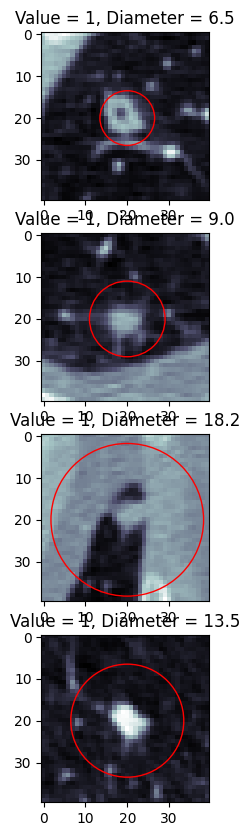

In [42]:
# Display the positive candidates (nodules)

numPositives = np.where(valuesArray==1)[0]

if (len(numPositives) > 1):
    plt.figure(figsize=(10,10))

for i, candidateNum in enumerate(numPositives):

    imgPatch = patchesArray[candidateNum]
    fig_name = path_join(EXTRACTED_PATCHES_DIR, f"candidate_{i}.png")
    plt.imsave(fig_name, imgPatch)
    plt.subplot(len(numPositives),1,i+1)
    plt.imshow(imgPatch, cmap='bone');
    plt.title('Value = {}, Diameter = {:.1f}'.format(valuesArray[candidateNum], noduleDiameter[candidateNum]));
    circle = plt.Circle((imgPatch.shape[0]/2, 
                         imgPatch.shape[1]/2), 
                        radius=noduleDiameter[candidateNum], fill=False, color='r')
    plt.gca().add_patch(circle)